In [67]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [68]:
graph = Graph.from_file("./VA_MUNI_DATA/va_precincts_all.shp")
print("Loaded graph")

/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(309, 320), (307, 320), (308, 309)}
  overlaps


Loaded graph


/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))
/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G16OHOR!
  warnings.warn("NA values found in column {}!".format(column))
/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column notes!
  warnings.warn("NA values found in column {}!".format(column))
/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column explain!
  warnings.warn("NA values found in column {}!".format(column))


In [69]:
print("Sample node data:")
print(graph.nodes[0])

Sample node data:
{'boundary_node': False, 'area': 13171012.745632773, 'precinct': 'Titustown', 'locality': 'Norfolk', 'loc_prec': 'Norfolk Titustown', 'district': 'Congressional District 2', 'G18DHOR': '666.0', 'G18DSEN': '680.0', 'G18OHOR': '0.0', 'G18OSEN': '12.0', 'G18RHOR': '87.0', 'G18RSEN': '68.0', 'G17DGOV': '516.0', 'G17DLTG': '519.0', 'G17DATG': '510.0', 'G17DHOD': '533.0', 'G17RGOV': '54.0', 'G17RLTG': '63.0', 'G17RATG': '70.0', 'G17RHOD': '0.0', 'G17OHOD': '0.0', 'G17OGOV': '11.0', 'G16DPRS': '772.0', 'G16RPRS': '135.0', 'G16OPRS': '49.0', 'G16DHOR': '780.0', 'G16RHOR': '149.0', 'G16OHOR': '0.0', 'notes': None, 'explain': None, 'TOTPOP': 8728, 'WHITE': 3234, 'AMIN': 74, 'ASIAN': 213, 'NHPI': 27, 'OTHER': 311, '2MORE': 529, 'VAP': 5943, 'DLS_BVAP': 2237, 'DLS_NONB': 3706, 'DOJ_BVAP': 2237, 'DOJ_NONB': 3706, 'SENPER': 0.909, 'ATGperc': 0.879, 'geometry': <shapely.geometry.polygon.Polygon object at 0x11d896b00>}


In [70]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "BVAP": updaters.Tally("DOJ_BVAP", alias="BVAP"),
    "VAP": updaters.Tally("VAP", alias="VAP")
}
initial_partition = GeographicPartition(graph, assignment="district", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)
dict_BVAP = {d : float(sum(
    [graph.nodes[n]["DOJ_BVAP"] for n in initial_partition.parts[d]]))/float(sum(
    [graph.nodes[n]["VAP"] for n in initial_partition.parts[d]])) for d in initial_partition.parts}

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [71]:
#What does this section do? Thomas told us to comment out
# BVAPS = []
# counter = 0
# for sample in range(0,3000):
#     counter += 1
#     if counter % 50 == 0:
#         print(counter, end=" ")
#     district = tree.bipartition_tree(graph, "TOTPOP", ideal_population, 0.02, 2)
#     BVAP = sum([graph.nodes[n]["DOJ_BVAP"] for n in district])
#     VAP = sum([graph.nodes[n]["VAP"] for n in district])
#     BVAPS.append(BVAP/VAP)

In [72]:
df_real = pd.read_csv("./VA_BVAP/DOJBVAP_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv("./VA_BVAP/DOJBVAP_{0}.csv".format(x), header=None)], ignore_index=True)

# BVAPS should be 1 long list of 11 BVAPS per row times number of rows
BVAPS = []
for j in range(11):
    for i in range(len(df_real.index)):
        ij = df_real.get_value(i,j)
        BVAPS.append(ij)

/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


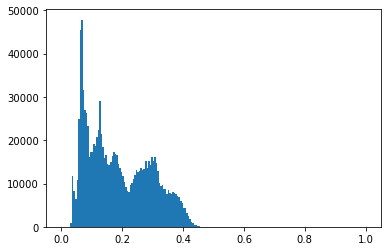

In [73]:
n_bins = 200
hist = plt.hist(BVAPS, bins=np.linspace(0, 1, n_bins+1, endpoint=True))
pdf = [x/sum(BVAPS) for x in hist[0]]

In [74]:
class BVAP_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

BVAPPDF = BVAP_pdf()

In [75]:
###MCMC time
vector = list(dict_BVAP.values())
print("Starting vector: ", vector)

counter = 0
list_of_vector_dicts = []
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = BVAPPDF._pdf(proposal[0])*BVAPPDF._pdf(proposal[1])/(BVAPPDF._pdf(vector[position1])*BVAPPDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df_simulated = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.1913996875828937, 0.4400019684451217, 0.10385156678342314, 0.05103286288668253, 0.20158574259632697, 0.13299328554562032, 0.1774155956888056, 0.16136410399611997, 0.4055859416352024, 0.0678184302765468, 0.11924110827848675]


Done generating simulated boxplot...
Done generating real boxplot...


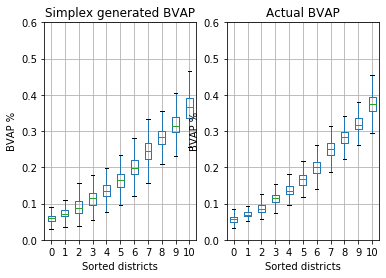

In [76]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated BVAP")
ax.set_ylabel("BVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual BVAP")
ax2.set_ylabel("BVAP %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 0.6)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_VA.png")

In [ ]:
# State-dependent variables
state = "VA"
num_districts = 11

In [112]:
# The following code calculates the BVAP % in each district and sorts them into a list
# The initial_partition is the enacted plan we think
# dict_BVAP is BVAP percents that thomas stored in dictionary (BVAP% = BVAP/VAP)

dict_BVAP_list = sorted(dict_BVAP.values())

# find the gap between each district
enacted_gaps = []
for i in range(num_districts-1):
    enacted_gaps.append(dict_BVAP_list[i+1] - dict_BVAP_list[i])

In [88]:
""" Generate the complementary cdfs
"""

# first, get the gaps loaded into a df
def get_dataframe_of_gaps(num_gaps_in_row, df):
    # Make a dataframe of gaps for the real data
    all_gaps = [] 

    for index, row in df.iterrows():
        gaps = dict()
        for j in range(num_gaps_in_row):
            gaps[j] = row[j+1] - row[j]
        all_gaps.append(gaps)

    return pd.DataFrame(all_gaps)

def get_complementary_cdfs(df, num_districts, xs):
    num_rows = len(df.index)

    # list of lists where list at index 0 is the complementary cdf of the first district
    complementary_cdfs = [[] for i in range(num_districts-1)]
    for x in xs:
        for i in range(num_districts-1):
            complementary_cdfs[i].append(len(df[df[i] > x][i])/num_rows)       
    
    return complementary_cdfs
            

gaps_real_df = get_dataframe_of_gaps(num_districts-1, df_real)
gaps_simulated_df = get_dataframe_of_gaps(num_districts-1, df_simulated)

xs = np.linspace(0.0, 0.2, num=200)
real_complementary_cdfs = get_complementary_cdfs(gaps_real_df, num_districts, xs)
simulated_complementary_cdfs = get_complementary_cdfs(gaps_simulated_df, num_districts, xs)


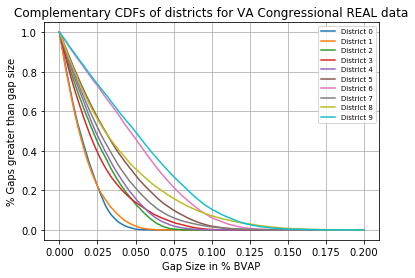

<Figure size 36000x18000 with 0 Axes>

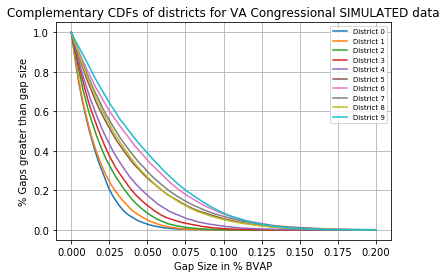

<Figure size 36000x18000 with 0 Axes>

In [89]:
""" Plot the complementary cdfs
"""

def plot_complementary_cdfs(complementary_cdfs, state, dtype, dest_folder):
    fig = plt.figure()
    legend_strs = []
    for i in range(num_districts-1):
        plt.plot(xs, complementary_cdfs[i])
        legend_strs.append("District "+ str(i))

    # plt.clf()
    plt.xlabel("Gap Size in % BVAP")
    plt.ylabel("% Gaps greater than gap size")
    plt.title("Complementary CDFs of districts for "+ state + " Congressional " + dtype + " data")
    plt.legend(legend_strs)
    plt.grid()
    params = {'legend.fontsize': 7,
              'legend.handlelength': 2}
    plt.rcParams.update(params)
    plt.figure(figsize=(120, 60), dpi=300) # doesnt save a high resolution image

    # plt.show()
    fig.savefig(dest_folder+ "cdf_" + state +"_" + dtype + ".png") 
    
plot_complementary_cdfs(real_complementary_cdfs, state, "REAL", "./plots/")
plot_complementary_cdfs(simulated_complementary_cdfs, state, "SIMULATED", "./plots/")

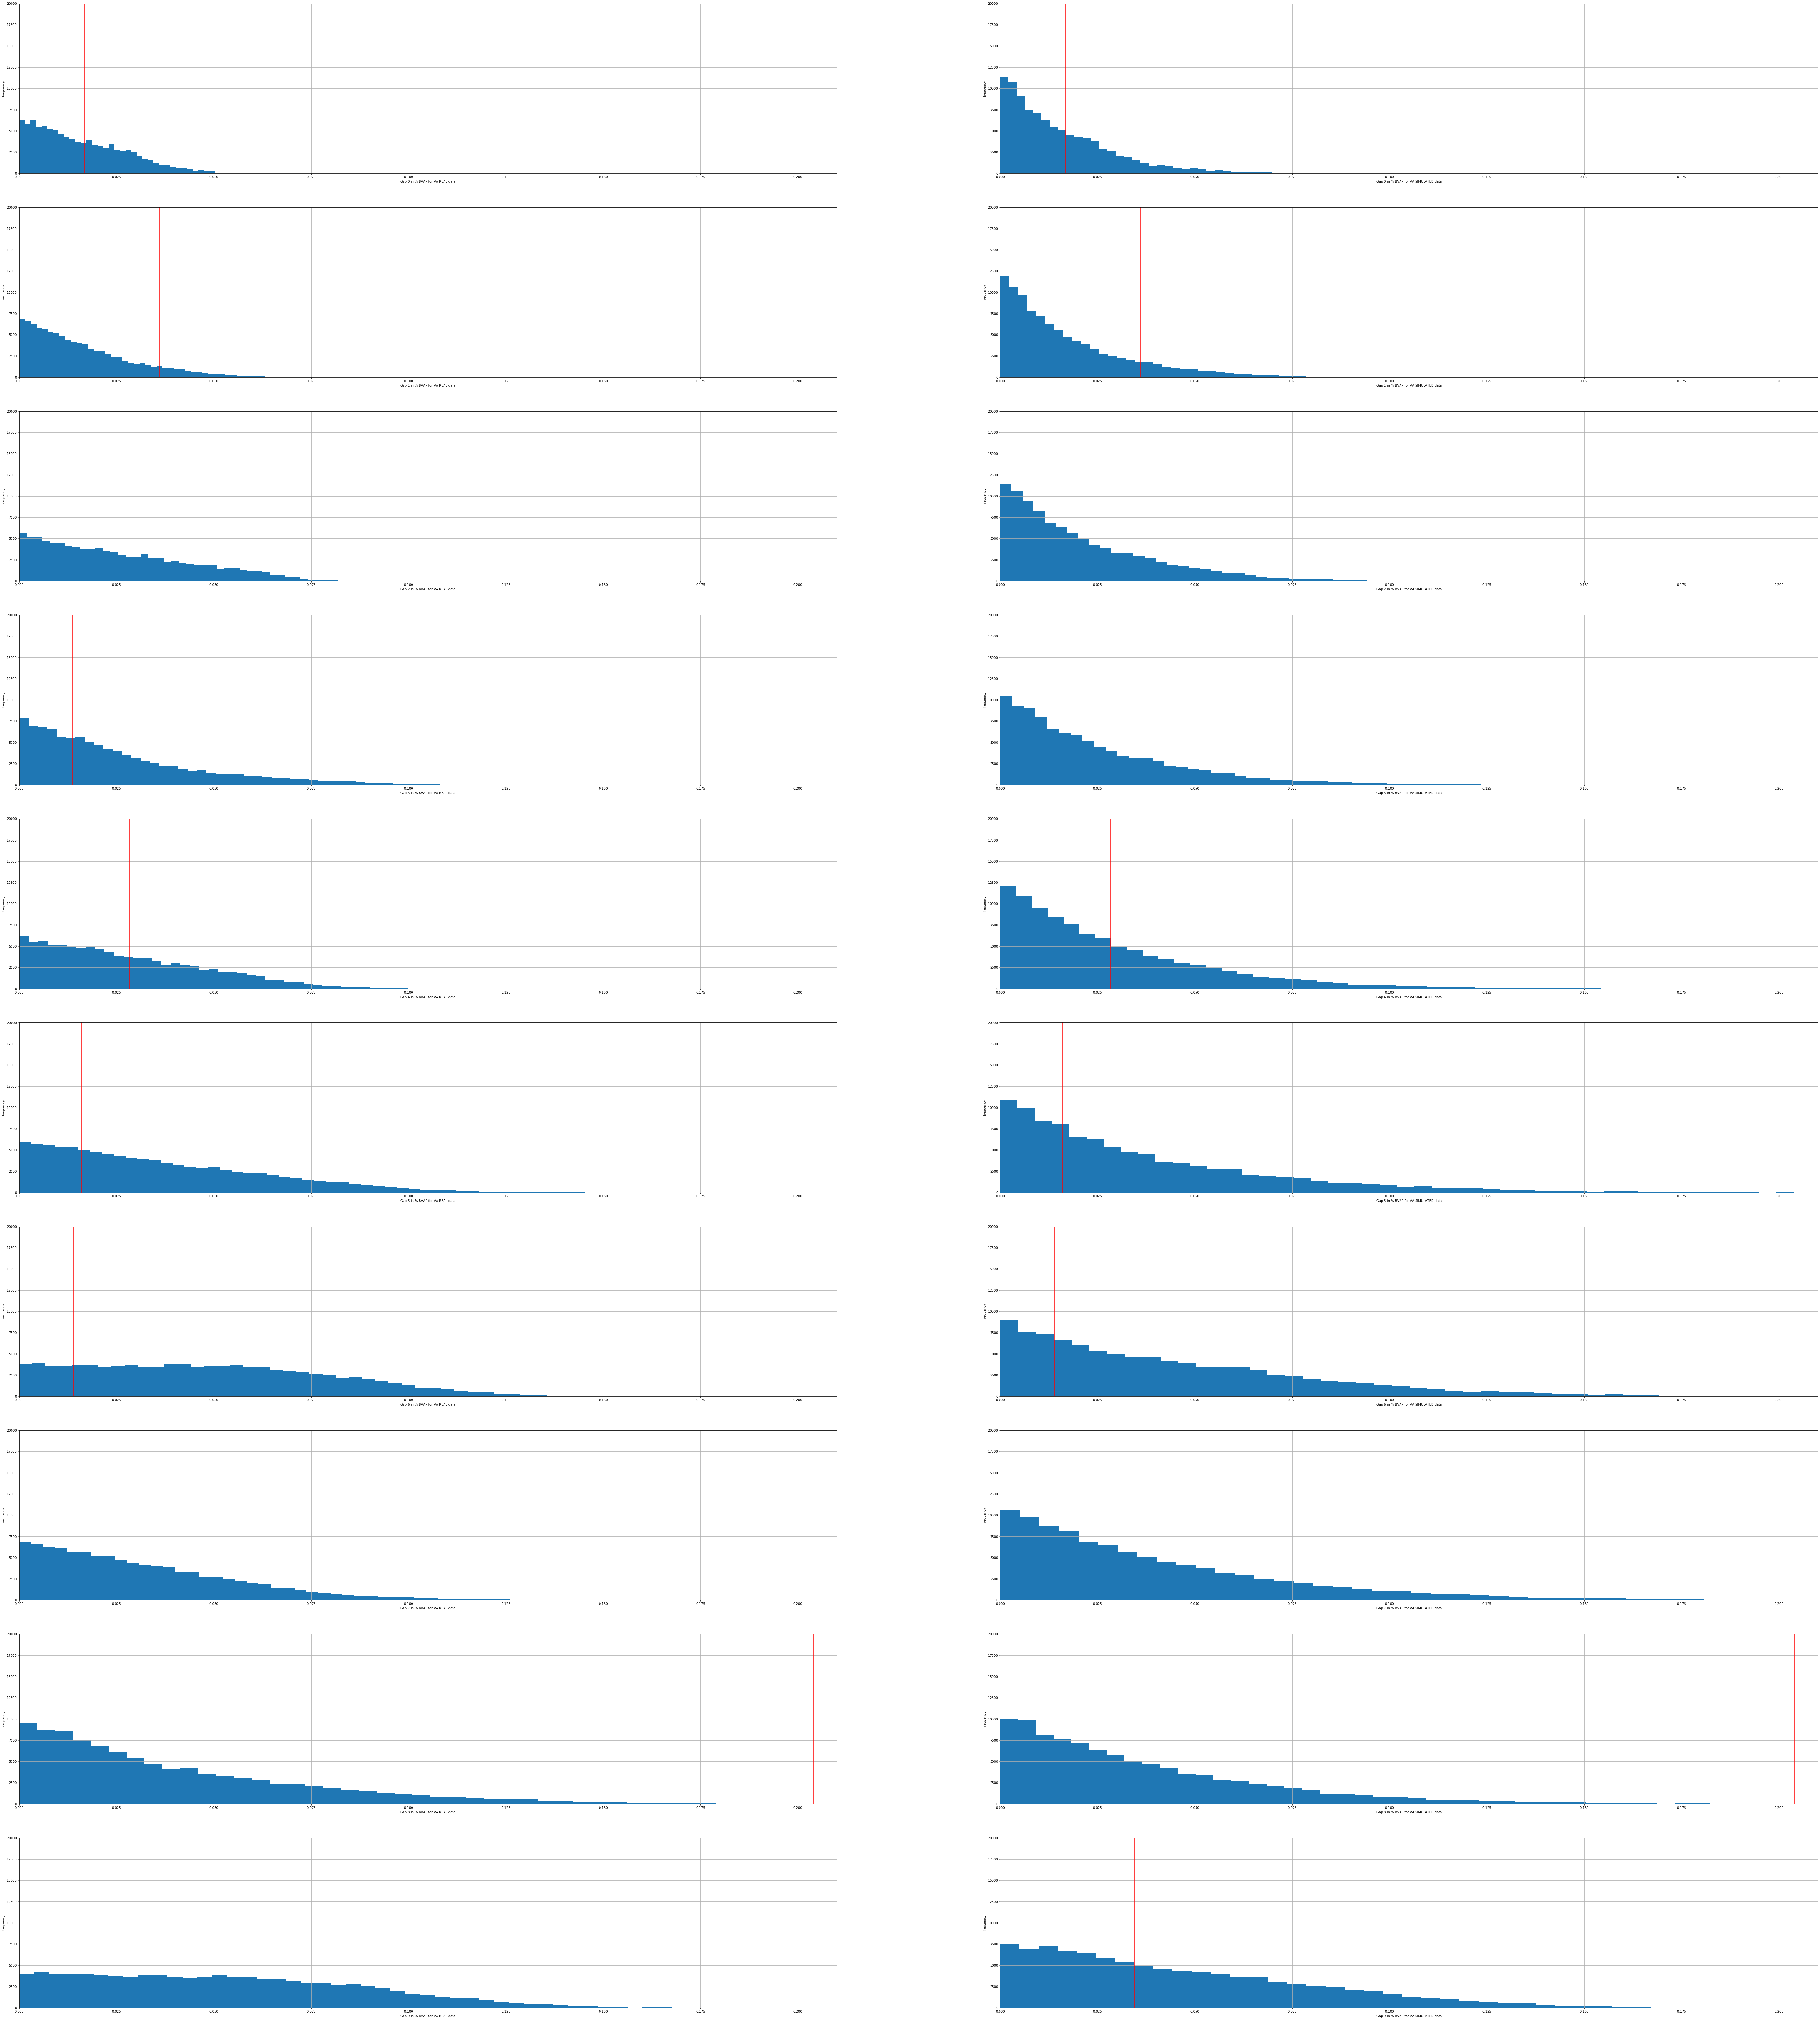

In [111]:
# Plot the gaps for real and simulated
fig = plt.figure(figsize=(20, 11))

index = 0
for i in range(1, num_districts):
    index += 1
    plt.subplot(num_districts-1, 2, index, ylim=(0,20000), xlim=(0, 0.21), 
                xlabel="Gap " + str(i-1) + " in % BVAP for " + state + " REAL data", 
                ylabel="frequency")
    plt.axvline(x=enacted_gaps[i-1], color="red")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=8, wspace=None, hspace=None)
    ax = gaps_real_df[i-1].hist(bins = 50)
    
    index += 1
    plt.subplot(num_districts-1, 2, index, ylim=(0,20000), xlim=(0, 0.21), 
                xlabel="Gap " + str(i-1) + " in % BVAP for " + state + " SIMULATED data", 
                ylabel="frequency")
    plt.axvline(x=enacted_gaps[i-1], color="red")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=8, wspace=None, hspace=None)
    ax = gaps_simulated_df[i-1].hist(bins = 50)
    
plt.savefig(dest_folder + state + "_hists.png", bbox_inches = 'tight')